# Lab 4 - Minis

**Estu:** Itzel Emily Velasquez Guerra
**Carrera:** Ing. Diseño y animacion digital

**Enlace del dataset:**  [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)

El dataset Ya viene dividido en dos archivos, uno de train y otro de test

Al ser un data set en csv las columnas usadas para la realización de la clasificación:

*   **Entrada:**  784 columnas, que tienen los pixeles de las imágenes a escala de grises con valores que van desde el 0 al 255.
*   **Salida:**
Etiqueta que va del 0 al 24, representando una letra del abecedario (A-Z)



# Clasificación Multiclase (One vs All)

## Introducción

En este ejercicio se implementa la regresion one-vs-all y una red neuronal para reconocimiento de digitos.


In [34]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Manejo de datos
import pandas as pd

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat

# Librería para realizar gráficos
import matplotlib.pyplot as plt

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

from scipy.interpolate import make_interp_spline



In [35]:
# Importación de archivos desde la nube de Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1 Cargamos los datos de entrenamiento
Como mencionamos, tenemos dividido nuestro data set en train datos y test datos. Ahora cargamos el train


In [102]:
# Las imágenes con las que trabajamos son de dígitos de 28x28
input_layer_size  = 784

# Tenemos 10 etiquetas lo cual seria: (0-9)
num_labels = 10

#  Cargamos los datos de entrenamiento
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/train2.csv')

# Asignamos valores a X y Y
X = data.iloc[:, 1:785].values
y = data.iloc[:, 0].values

m = y.size

# Comprobamos los tamaños
print(X.shape)
print( y.shape)

(60000, 784)
(60000,)


### Visualización de los datos

Creamos la función **displayData** , que nos servira para poder representar gráficamente las dimensiones de las imágenes de tamaño 28x28 pixeles.

In [103]:
def displayData(X, example_width=None, figsize=(10, 10)):

    X = np.array(X)  # Convertir a arreglo de numpy

    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Check if the index is within bounds
        if i < m:
            ax.imshow(X[i].reshape(example_width, example_width, order='C'),
                      cmap='Greys', extent=[0, 1, 0, 1], aspect='equal', origin='upper')
        ax.axis('off')

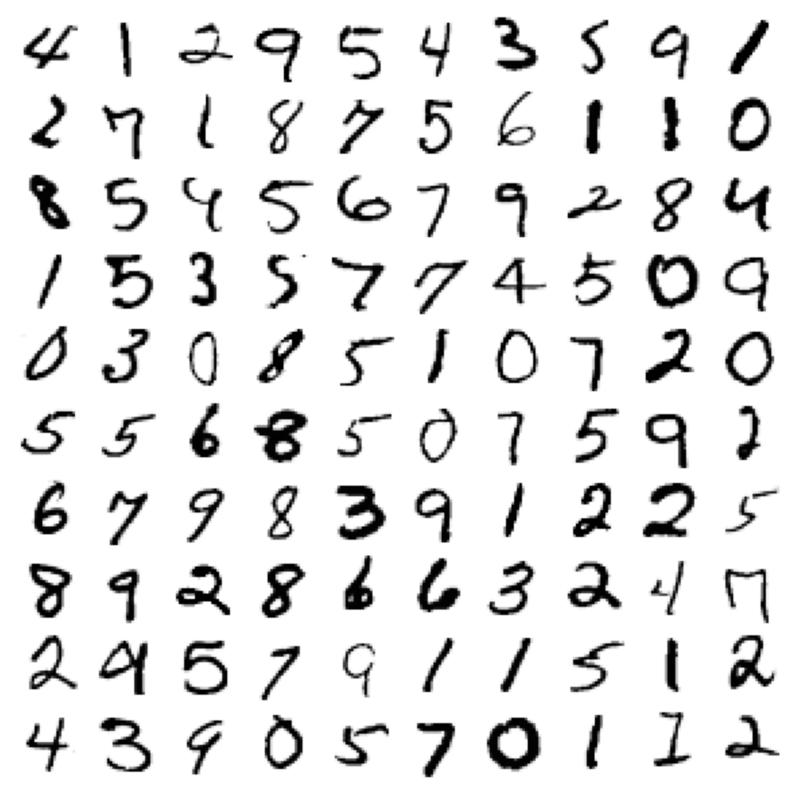

In [104]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
X_img = X[rand_indices, :]

displayData(X_img)

### 1.2 Vectorización de regresión logística

En este caso tenemos 25 clasespor eso se utilizará múltiples modelos de regresión logística uno contra todos para construir un clasificador de clases múltiples. Dado que hay 25 clases, deberá entrenar 25 clasificadores de regresión logística separados.



Para probar la regresión logística vectorizada, se usara datos personalizados como se definen a continuación.

In [87]:
# valores de prueba para los parámetros theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# valores de prueba para las entradas
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# valores de testeo para las etiquetas
y_t = np.array([1, 0, 1, 0, 1])

# valores de testeo para el parametro de regularizacion
lambda_t = 3


#### Vectorización de la funcion de costo
Para esta vectorizacion creamos la función de la sigmoide.

In [88]:
# convertir cualquier valor de entrada en un valor de salida entre 0 y 1.
def sigmoid(z):

    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

In [41]:
#Funcion de costo y gradiente
def lrCostFunction(theta, X, y, lambda_):
    m = y.size

    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    # Evitar valores de h que sean 0 o 1
    epsilon = 1e-10
    h = np.clip(h, epsilon, 1 - epsilon)

    temp = theta.copy()
    temp[0] = 0

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    return J, grad


#### 1.2.3 Vectorización regularizada de la regresión logística

Añadimos regularización a la función de costo.


In [89]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Costo: {:.6f}'.format(J))


Costo: 2.534819


In [90]:
print('Gradientes calculados:')
for i, val in enumerate(grad, 1):
    print(f'Gradiente {i}: {val:.6f}')

Gradientes calculados:
Gradiente 1: 0.146561
Gradiente 2: -0.548558
Gradiente 3: 0.724722
Gradiente 4: 1.398003


### Clasificacion One-vs-all
A continuación, se implementará la clasificación one-vs-all. Esto implica entrenar varios clasificadores de regresión logística regularizados, uno para cada clase en el conjunto de datos.

Además, se utilizará una función para visualizar el costo.

También haremos uso de la función para graficar el costo.







In [91]:
def oneVsAll(X, y, num_labels, lambda_):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.concatenate([np.ones((m, 1)), X], axis=1)  # Añadir columna de unos para el término de sesgo

    cost_histories = [[] for _ in range(num_labels)]  # Lista de listas para almacenar el costo por iteración para cada clase

    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 100, 'disp': False}

        # Función callback para almacenar el costo en cada iteración
        def callback(theta):
            cost, _ = lrCostFunction(theta, X, (y == c), lambda_)
            cost_histories[c].append(cost)

        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                args=(X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                callback=callback,  # Usar el callback aquí
                                options=options)

        all_theta[c] = res.x

        print(f'Theta para la clase {c}: {res.x}')

    return all_theta, cost_histories

In [92]:
#Agragamos valor a lamnda
lambda_ = 0.01
#Llamamos a la funcion
all_theta, cost_histories  = oneVsAll(X, y, num_labels, lambda_)


Theta para la clase 0: [-3.81634661e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.46965225e-04 -2.13595370e-03 -1.28780227e-03
 -5.36584324e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.26452290e-04 -4.40704366e-04 -4.04799030e-03
 -1.17545827e-02 -2.60946345e-02 -4.89379975e-02 -9.68138074e-02
 -3.54464276e-02  4.60174368e-02 -3.37424539e-02 -1.32446270e-01
 -6.49361960e-02 -1.57526355e-02 -5.60126640e-02 -8.19584065e-02
 -4.94795988e-02 -3.83224202e-02 -2.72439380e-02 -1.04892104e-02
 -8.22892155e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.46029110e-04
  

#### Gráficar COSTO


In [93]:
def plot_cost(cost_histories): #Función para graficar la evolución del costo a lo largo de las iteraciones.
    plt.figure(figsize=(12, 8))
    for i in range(num_labels):
        plt.plot(cost_histories[i], label=f'Clase {i}')
    plt.xlabel('Número de iteraciones')
    plt.ylabel('Costo')
    plt.title('Costo durante la optimización para cada clase')
    plt.legend()
    plt.show()

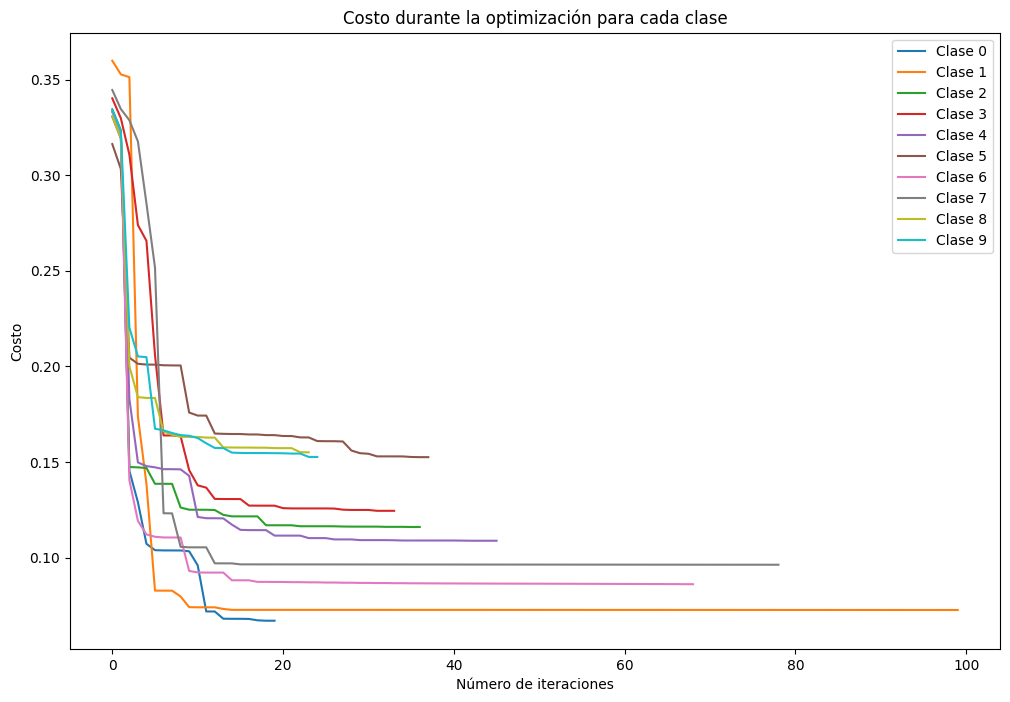

In [94]:
#Llamamos a la funcion
plot_cost(cost_histories)

### Prediccion One-vs-all


In [95]:
#Por cada dato de entrada,calcular la probabilidad de que pertenezca a cada clase usando los clasificadores de regresión logística.

def predictOneVsAll(all_theta, X):

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Añade una columna de 1
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

#### Cargamos los datos de prueba


In [105]:
#  Cargamos los datos de entrenamiento
data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/t10k.csv')


X_test = data_test.iloc[:, 1:785].values
y_test = data_test.iloc[:, 0].values

m_test = y_test.size
# Comprobamos los tamaños
print(X_test.shape)
print(y_test.shape)

(10000, 784)
(10000,)


#### Precisión y predicción


In [106]:
#Precisión con el 80% de los datos.
pred_train = predictOneVsAll(all_theta, X)
print('Precision del entrenamiento: {:.2f}%'.format(np.mean(pred_train == y) * 100))

Precision del entrenamiento: 88.55%


In [107]:
#Precisión con el 20% de los datos.
pred_test = predictOneVsAll(all_theta, X_test)
print('Precision de prueba: {:.2f}%'.format(np.mean(pred_test == y_test) * 100))

Precision de prueba: 89.23%


In [108]:
#Predicción con los datos de prueba.

def select_random_data(X, y, m, num_samples=50):
  #selecciona aleatoriamente un subconjunto de datos de un conjunto de datos más grande.
    rand_indices = np.random.choice(m, num_samples, replace=False)
    return X[rand_indices, :], y[rand_indices]

In [109]:
def plot_results(X, y, all_theta): #predicción de clases utilizando un modelo de regresión logística
    X_with_ones = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    #Añade una columna a X para incluir el término de sesgo (intercepto)
    predictions = np.argmax(sigmoid(X_with_ones.dot(all_theta.T)), axis=1) #realiza las predicciones
    print(f'Predicciones: {predictions}')
    print(f'Valores reales: {y}')

    # Graficar los resultados
    displayData(X)

Predicciones: [3 7 2 4 0 0 7 6 7 9 3 3 7 7 9 0 6 4 3 0 4 2 1 5 5 5 5 6 8 8 5 3 3 1 3 0 0
 3 2 3 9 5 1 1 8 0 9 3 0 1]
Valores reales: [3 7 2 4 0 6 8 6 7 9 3 1 7 7 9 0 6 8 3 0 4 2 1 5 5 5 5 6 8 5 5 3 3 1 3 0 0
 3 2 3 9 4 1 1 8 2 9 3 0 1]


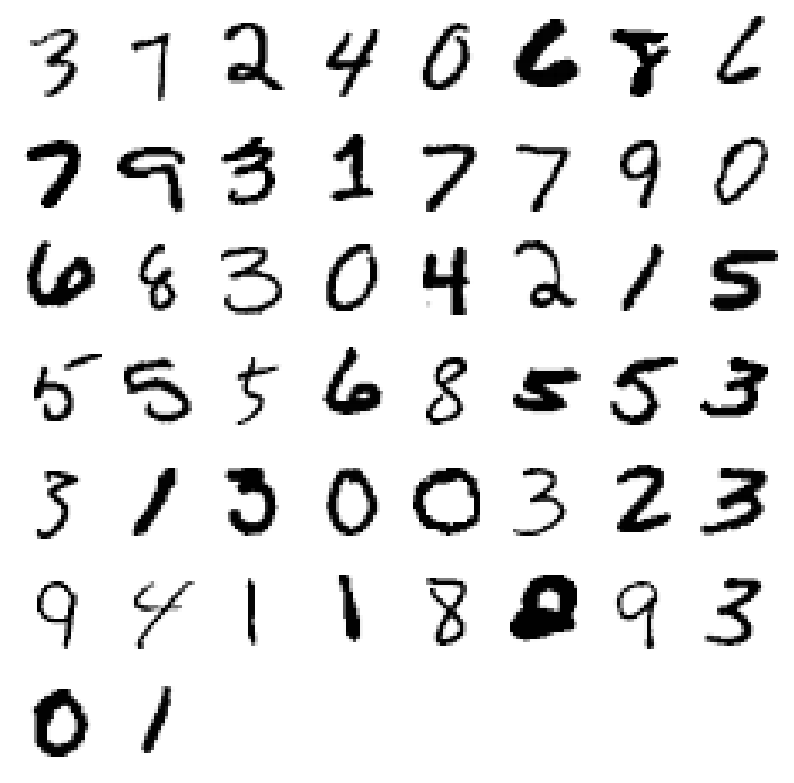

In [110]:
# Seleccionar datos aleatoriamente
X_sample, y_sample = select_random_data(X_test, y_test, m_test)

# Graficar resultados
plot_results(X_sample, y_sample, all_theta)